In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

#from mcjax.proba.dist import Dist
from mcjax.proba.neal_funnel import NealFunnel
from mcjax.mcmc.core import run_mcmc
from mcjax.mcmc.rwm import rwm_kernel
from mcjax.util.mcmc import ess_ar1, normalized_autocorr
from mcjax.util.plot_2d import evaluate_on_grid_2d



In [2]:
# initialize jax RNG
key = jr.key(0)

### Neal's Funnel target distribution


In [3]:
dist = NealFunnel()
logdensity = dist.logdensity
logdensity_batch = jax.vmap(logdensity)

Text(0.5, 1.0, 'Neal funnel logpdf')

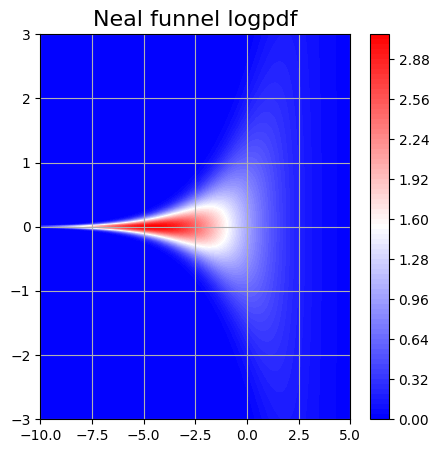

In [4]:
xmin, xmax = -10, 5
ymin, ymax = -3, 3
X, Y, Z = evaluate_on_grid_2d(
    func_batch=logdensity_batch,
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    Nx=500,
    Ny=500
)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.grid()
plt.title('Neal funnel logpdf', fontsize=16)


### Run RWM

In [6]:
kernel = rwm_kernel(logdensity, step_size=0.1, cov=jnp.eye(2))
x_init = jnp.array([0., 0.])
state, params = kernel.init(x_init)
n_samples = 10_000
mcmc_output = run_mcmc(
                step=kernel.step,
                init_state=state,
                params=params,
                key=key,
                n_samples=n_samples,
                summarize=kernel.summarize)
traj = mcmc_output.traj
summary = mcmc_output.summary

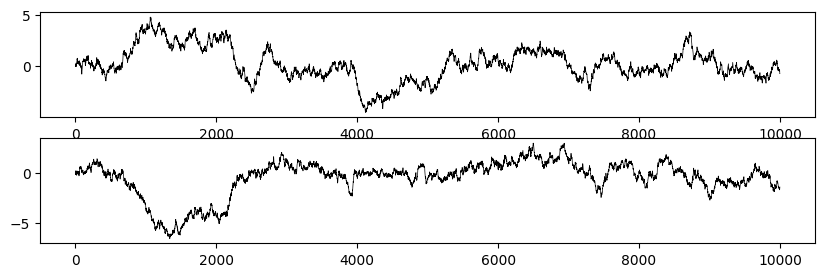

In [7]:
# plot x0 trajectory
plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(traj.x[:, 0], color='black', lw=0.5)
plt.subplot(2, 1, 2)
plt.plot(traj.x[:, 1], color='black', lw=0.5)

### Influence of the step size

In [8]:
# Define a function that samples a trajectory using RWM
def sample_RWM(key, x0, step_size, n_steps):
    # Create the RWM kernel
    kernel = rwm_kernel(logdensity=logdensity, step_size=step_size, cov=jnp.eye(2))
    
    # Initialize the state and parameters
    state, params = kernel.init(x0)
    
    # Run MCMC
    mcmc_output = run_mcmc(
        step=kernel.step,
        init_state=state,
        params=params,
        key=key,
        n_samples=n_steps,
        summarize=kernel.summarize
    )
    return mcmc_output

# JIT compile the sampler for a single trajectory
sample_RWM = jax.jit(sample_RWM, static_argnums=(3,)) 

# Define a batched version over multiple step sizes
sample_RWM_batch = jax.vmap(sample_RWM, in_axes=(None, None, 0, None))
sample_RWM_batch = jax.jit(sample_RWM_batch, static_argnums=(3,))


In [9]:
x0 = jnp.array([0., 0.])
step_size = 0.1
n_steps = 1_000_000
key, key_ = jr.split(key)
mcmc_output = sample_RWM(key_, x0, step_size, n_steps)

In [10]:
step_size_arr = np.linspace(0.01, 10., 100)
n_steps = 1_000_000
key, key_ = jr.split(key)
mcmc_output_batch = sample_RWM_batch(key_, x0, step_size_arr, n_steps)
traj_batch = mcmc_output_batch.traj
summary_batch = mcmc_output_batch.summary


Text(0.6, 0.6, 'Optimal step size: 5.86 \n Acceptance rate: 0.11')

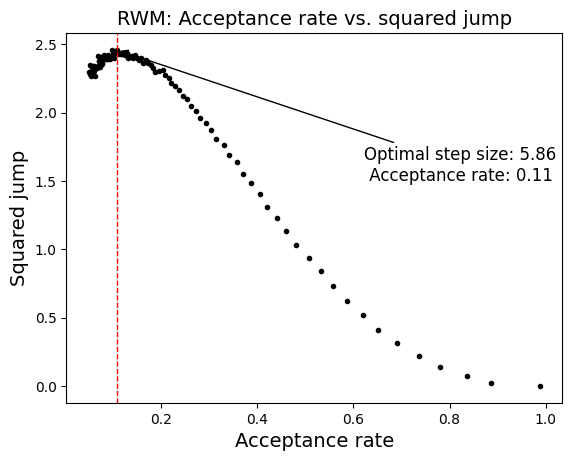

In [11]:
plt.plot(summary_batch.acceptance_rate, summary_batch.sq_jump, ".", color='black')
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Squared jump", fontsize=14)
plt.title("RWM: Acceptance rate vs. squared jump", fontsize=14)

# find the optimal step size by maximizing the squared jump
index_opt = np.argmax(summary_batch.sq_jump)
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = summary_batch.acceptance_rate[index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {optimal_acceptance_rate:.2f}",
                xy=(optimal_acceptance_rate, summary_batch.sq_jump[index_opt]),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)

In [12]:
# now, let's tune by maximizing the effective sample size
ess_ar1_list = [ess_ar1(traj_batch.x[k,:,0]) for k in range(len(step_size_arr))]

Text(0.5, 1.0, 'RWM: Acceptance rate vs. ESS (Geyer)')

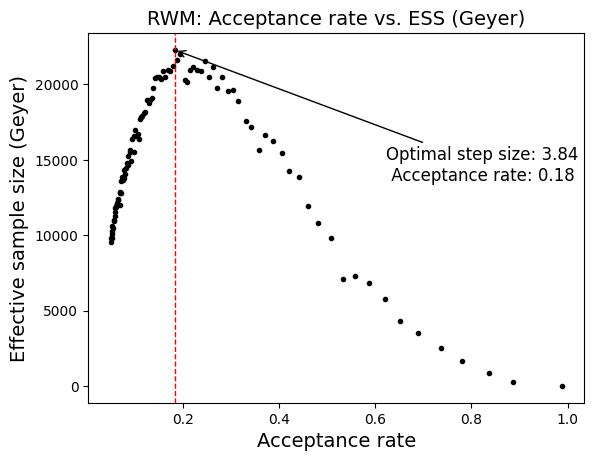

In [13]:
plt.plot(summary_batch.acceptance_rate, ess_ar1_list, ".", color='black')
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Effective sample size (Geyer)", fontsize=14)

# find the optimal step size by maximizing the ESS
index_opt = np.argmax(ess_ar1_list)
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = summary_batch.acceptance_rate[index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {optimal_acceptance_rate:.2f}",
                xy=(optimal_acceptance_rate, ess_ar1_list[index_opt]),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)
plt.title("RWM: Acceptance rate vs. ESS (Geyer)", fontsize=14)

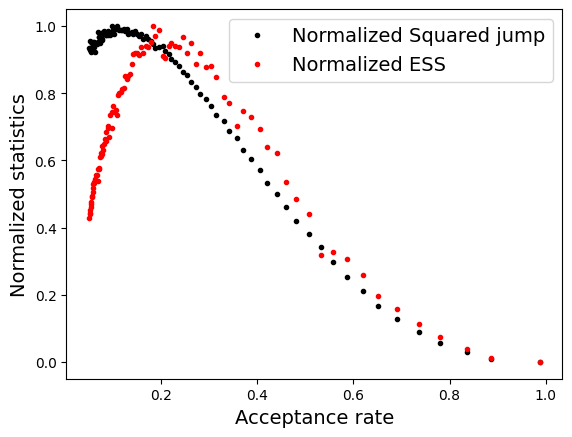

In [14]:
# compare ESS vs squared jump statistics
max_sq_jump = np.max(summary_batch.sq_jump)
plt.plot(summary_batch.acceptance_rate, summary_batch.sq_jump/max_sq_jump, ".", color='black', label="Normalized Squared jump")
max_ess_geyer = np.max(ess_ar1_list)
plt.plot(summary_batch.acceptance_rate, ess_ar1_list/max_ess_geyer, ".", color='red', label="Normalized ESS")
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Normalized statistics", fontsize=14)
plt.legend(fontsize=14)


Text(0.5, 1.0, 'RWM: Autocorrelation function')

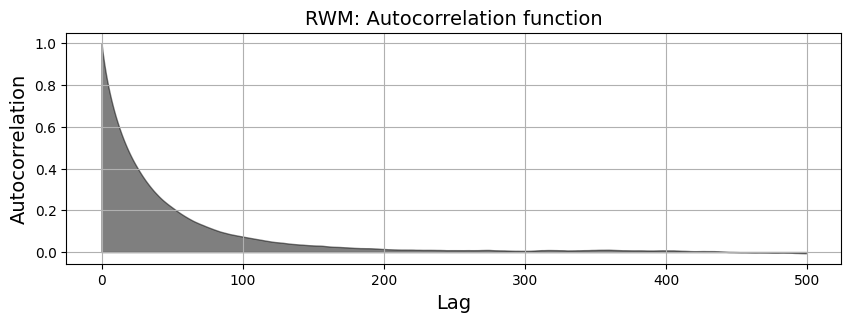

In [15]:
# plot the autocorrelation function at the optimal step size
# trajectory = traj_batch.x[0, :, 0]
trajectory = traj_batch.x[index_opt, :, 0]
autocorr = normalized_autocorr(trajectory)

# plot with fill_between
plt.figure(figsize=(10, 3))
max_lag = 500
plt.fill_between(np.arange(max_lag), [0 for _ in range(max_lag)], autocorr[:max_lag], color='black', alpha=0.5)
plt.xlabel("Lag", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.grid()
plt.title("RWM: Autocorrelation function", fontsize=14)

In [16]:
# run a chain with the optimal step size
key, key_ = jr.split(key)
n_samples = 1_000_000
mcmc_output_opt = sample_RWM(key_, x0, optimal_step_size, n_steps)
traj_opt = mcmc_output_opt.traj
summary_opt = mcmc_output_opt.summary

Text(0.5, 1.0, 'Samples from the target distribution')

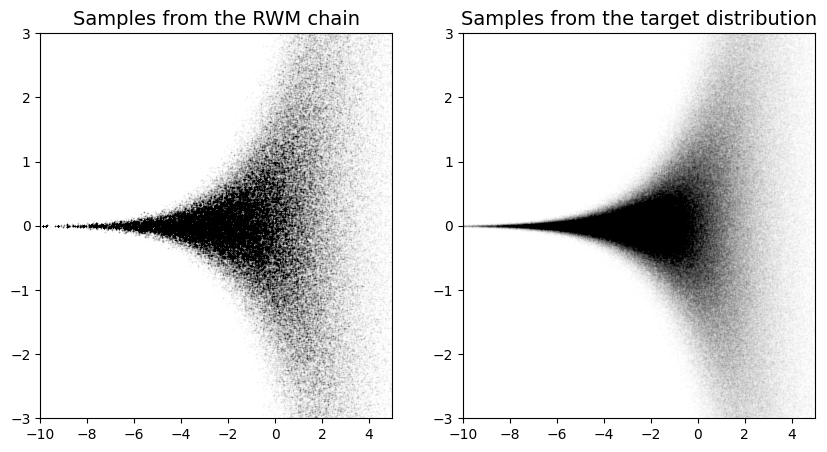

In [17]:
# scatter plot of the samples
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(traj_opt.x[:, 0], traj_opt.x[:, 1], s=1, color='black', marker='.', alpha=0.01)
plt.title("Samples from the RWM chain", fontsize=14)

# samples from the target distribution
key, key_ = jr.split(key)
true_samples = dist.sample(key_, n_samples)
plt.subplot(1,2,2)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(true_samples[:, 0], true_samples[:, 1], s=1, color='black', marker='.', alpha=0.01)
plt.title("Samples from the target distribution", fontsize=14)

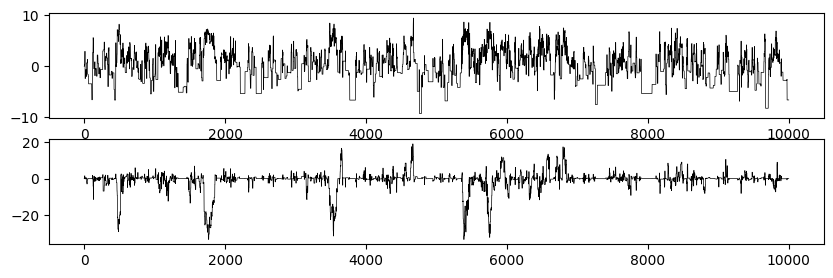

In [18]:
# plot x0 trajectory
plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(traj_opt.x[:10_000, 0], color='black', lw=0.5)
plt.subplot(2, 1, 2)
plt.plot(traj_opt.x[:10_000, 1], color='black', lw=0.5)